<a href="https://colab.research.google.com/github/scheijan/notebooks/blob/master/T_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations
Mount Google Drive and import all necessary libraries


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read and prepare the data
Read the data from the CSV file into a Pandas dataframe. Remove all columns which are not used, we only need the two names and the proximity.


In [4]:
df = pandas.read_csv('/content/drive/My Drive/Colab Notebooks/GKB_usedTBs.csv', header=None, sep='\n')
df = df[0].str.split('\t', expand=True)
df.columns = ['name1', 'length1', 'name2', 'length2', 'countHits', 'lengthHits', 'proximity']
del df['length1']
del df['length2']
del df['lengthHits']
del df['countHits']

df.describe()

,name1,name2,proximity
count,72505,72505,72505
unique,718,724,1824
top,Schuldanerkennung,Schuldanerkennung,0.97%
freq,836,1015,1526


Find all names that only exist in either the first or the second column and create a cleaned, distinct list of all names.

In [0]:
u1 = df['name1'].unique()
u2 = df['name2'].unique()

missing1 = [a for a in u1 if a not in u2]
missing2 = [a for a in u2 if a not in u1]
missing = len(missing1) + len(missing2)

In [0]:
allNames = []
for name in u1:
  if name in u2:
    allNames.append(name)

for name in u2:
  if name in u1:
    allNames.append(name)

allNames = list(set(allNames))
allNames.sort()

Create a distance matrix (np array) from the cleaned data.

In [0]:
matrix = np.full((len(allNames), len(allNames)), 0.5)

for i, row in df.iterrows():
  n1, n2, value = row
  if n1 in allNames and n2 in allNames:
    i1 = allNames.index(n1)
    i2 = allNames.index(n2)

    value = value.replace('%', '')
    value = 1 - float(value) / 100
    # print('%s %s - %s - %s %s' % (n1, i1, value, n2, i2))
    
    if n1 in missing2 or n2 in missing1:
      pass
    elif i1 == i2:
      matrix[i1, i2] = 0
    else:
      matrix[i1, i2] = value

# Clustering on a 2d plane using T-SNE

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=2000, metric='precomputed')
tsne_results = tsne.fit_transform(matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 605 samples in 0.001s...
[t-SNE] Computed neighbors for 605 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 605 / 605
[t-SNE] Mean sigma: 0.082183
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.218842
[t-SNE] KL divergence after 1450 iterations: 0.817513


Add the T-SNE results to the distance matrix and plot it.

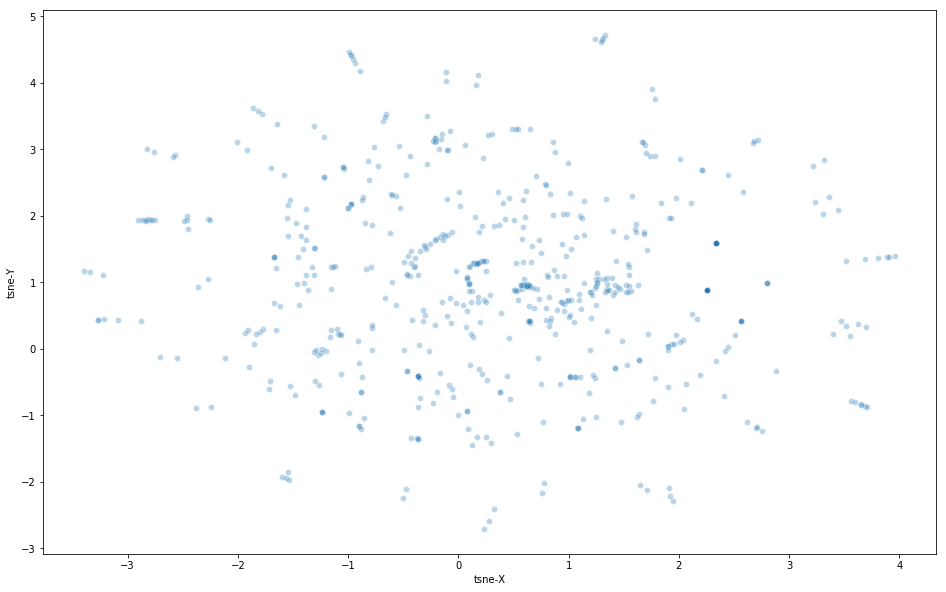

In [16]:
matrix = pandas.DataFrame(matrix)

matrix['tsne-X'] = tsne_results[:,0]
matrix['tsne-Y'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-X", y="tsne-Y",
    palette=sns.color_palette("hls", 10),
    data=matrix,
    legend="full",
    alpha=0.3
)